In [407]:
import requests
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient

## I will be using the companies database from Crunchbase, because I believe the US has the best ecosystem for StartUps in general

In [410]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost/companies")
db = client.get_database()

 Let's find the companies in the design sector, so that: `Designers like to go to design talks and share knowledge. There must be some nearby companies that also do design.`

In [411]:
companies = db.companies.find({})
df = pd.DataFrame(list(companies))

df["category_code"].value_counts()


web                 3787
software            2736
games_video         1083
mobile              1018
other                986
advertising          928
enterprise           742
ecommerce            688
consulting           637
network_hosting      626
public_relations     533
search               394
biotech              373
hardware             368
cleantech            305
semiconductor        167
security             156
analytics             66
finance               49
social                49
news                  48
education             36
music                 33
messaging             30
travel                25
legal                 25
medical               25
photo_video           23
health                23
manufacturing         19
sports                13
real_estate           10
fashion               10
automotive             9
hospitality            8
transportation         7
nanotech               5
nonprofit              4
design                 4
local                  1


From these categories, I will be focusing on "design", "web" and "games_video" because I believe those are the ones that do design in the same way we do. I will be cleaning the dataframe and then convert it into a json.

In [412]:
query = {
      "$or":[
        {"category_code":"web"},
        {"category_code":"games_video"},
        {"category_code":"design"}
    ]
}

companies_design = db.companies.find(query)
data = list(companies_design)

In [413]:
df_design = pd.DataFrame(data)
df_design["total_money_raised"].head(20)
#df_design.shape

0     $39.8M
1         $0
2         $0
3     $16.5M
4     $18.5M
5         $0
6     $18.1M
7     $44.2M
8       $45M
9     $13.2M
10        $0
11    $28.3M
12     $6.7M
13        $0
14      $21M
15    $69.8M
16    $23.4M
17       $1M
18     $8.4M
19        $0
Name: total_money_raised, dtype: object

Now let's find companies that fit this requirement: `Developers like to be near successful tech startups that have raised at least 1 Million dollars`

In [414]:
# First we have to clean the 'total_money_raised' column: Let's use regex to extrac the number from the string

def convertMoneyToInt(txt):
    try:
        if "M" in txt: # to indicate that we only keep Millions
            money = re.sub('M', '', txt)
            money2 = re.findall(r"\d.+",money)
            return "".join(money2)
        else:
            return None
    except:
        return None
    

df_design["total_money_raised"] = df_design["total_money_raised"].apply(convertMoneyToInt)
df_design["total_money_raised"].head(20)

0     39.8
1     None
2     None
3     16.5
4     18.5
5     None
6     18.1
7     44.2
8       45
9     13.2
10    None
11    28.3
12     6.7
13    None
14      21
15    69.8
16    23.4
17        
18     8.4
19    None
Name: total_money_raised, dtype: object

In [415]:
df_design.shape

(4874, 42)

In [416]:
df_design.dropna(subset = ["total_money_raised"], inplace=True)
df_design = df_design.reset_index(drop=True)

In [417]:
df_design.shape

(834, 42)

In [418]:
df_design.deadpooled_year.isnull()

0      False
1       True
2       True
3       True
4       True
       ...  
829    False
830     True
831     True
832     True
833     True
Name: deadpooled_year, Length: 834, dtype: bool


Now we have all the companies in the categories "Design", "Web", and "games_video" that have raised over 1M USD, but we have to take into account that the companies that have been deadpooled cannot be considered as "succesful". Therefore, I am removing all the deadpooled companies from the data frame. 


In [419]:
df_design = df_design[df_design.deadpooled_year.isnull() == True]
df_design = df_design.reset_index(drop=True)

In [420]:
df_design.shape

(693, 42)

In [421]:
# Let's see what it is that we still have to clean: We can see that there are a lot of blank spaces that weren't erased

df_design["total_money_raised"].value_counts()

        153
10       20
1.5      13
2.5      11
12        8
       ... 
12.5      1
28.5      1
136       1
31.4      1
91.5      1
Name: total_money_raised, Length: 324, dtype: int64

In [422]:
def makeFloat(txt):
    try:
        return float(txt)
    except:
        return 0
    
df_design["total_money_raised"].apply(makeFloat)

0      16.50
1      18.50
2      18.10
3      44.20
4      45.00
       ...  
688     1.70
689     6.10
690     0.00
691    17.20
692     1.17
Name: total_money_raised, Length: 693, dtype: float64

In [423]:
df_design["total_money_raised"].value_counts()

        153
10       20
1.5      13
2.5      11
12        8
       ... 
12.5      1
28.5      1
136       1
31.4      1
91.5      1
Name: total_money_raised, Length: 324, dtype: int64

In [424]:
#Dropping of the rows with no info for total_money_raised
df_design.dropna(subset = ["total_money_raised"], inplace=True)

In [425]:
df_design.shape

(693, 42)

Now, let's create a new column called state to be able to visualize where are the most succesful startups in the "web", "games_video", "design" categories.


In [426]:
df_design=df_design.explode('offices')

In [427]:
df_design.shape

(838, 42)

In [428]:
def getState(x):
    try:
        return x["state_code"]
    except:
        return"unknown"
    
df_design['state'] = df_design["offices"].apply(getState)

In [429]:
def getCity(x):
    try:
        return x["city"]
    except:
        return"unknown"
    
df_design['city'] = df_design["offices"].apply(getCity)

In [430]:
df_design.state.value_counts()

CA         311
NY          95
unknown     31
MA          25
WA          23
IL          12
TX          11
FL          10
VA           9
PA           8
NV           5
UT           5
GA           4
MD           4
OH           3
IN           3
CO           3
NC           3
CT           3
KY           3
DC           2
WI           2
AZ           2
TN           1
MN           1
MI           1
OR           1
             1
NJ           1
LA           1
AL           1
Name: state, dtype: int64

In [438]:
df_design.city.value_counts().head(50)

San Francisco       101
New York             84
unknown              31
London               27
Palo Alto            23
Mountain View        23
Seattle              21
Los Angeles          19
                     16
Santa Monica         15
Paris                14
San Mateo            14
Beijing              12
Sunnyvale            11
Redwood City         10
Austin                9
San Diego             9
Berlin                9
Boston                8
Cambridge             8
Chicago               8
Tel Aviv              7
Stockholm             6
Shanghai              6
Bangalore             6
Singapore             5
San Jose              5
New York City         4
Edinburgh             4
Santa Clara           4
Culver City           4
Ramat Gan             4
Brooklyn              4
Toronto, Ontario      3
Andover               3
Champaign             3
Buenos Aires          3
Seoul                 3
Tokyo                 3
West Hollywood        3
Reston                3
Moscow          

In [432]:
df_design.shape

(838, 44)

<Figure size 864x216 with 0 Axes>

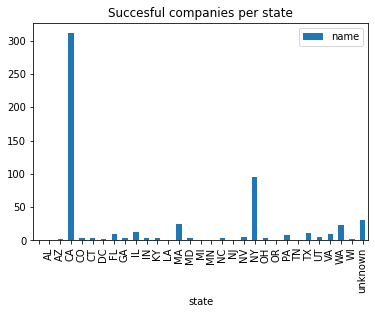

In [435]:
plt.figure(figsize=(12,3))
plot=df_design.groupby("state").agg({"name":"count"}).plot.bar()
plt.xticks( rotation=90)
plt.title('Succesful companies per state')
plt.show()



#### Based on the number of succesful companies in the categories specified earlier, we can see that CA is the best state for our HQ. Now let's look at the city that best suits us.

<Figure size 864x216 with 0 Axes>

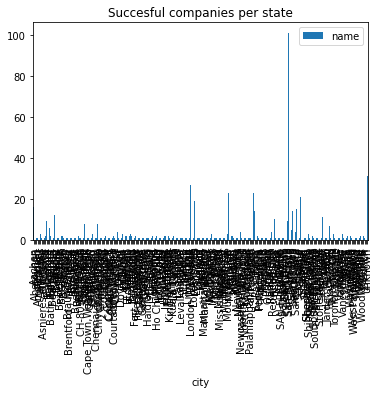

In [436]:
plt.figure(figsize=(12,3))
plot=df_design.groupby("state").agg({"name":"count"}).plot.bar()
plt.xticks( rotation=90)
plt.title('Succesful companies per state')
plt.show()

In [437]:

sns.factorplot(x="state", y="total_money_raised", hue='category_code', data=df_design, kind='bar')

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: Neither the `x` nor `y` variable appears to be numeric.